100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
データの数: 10000


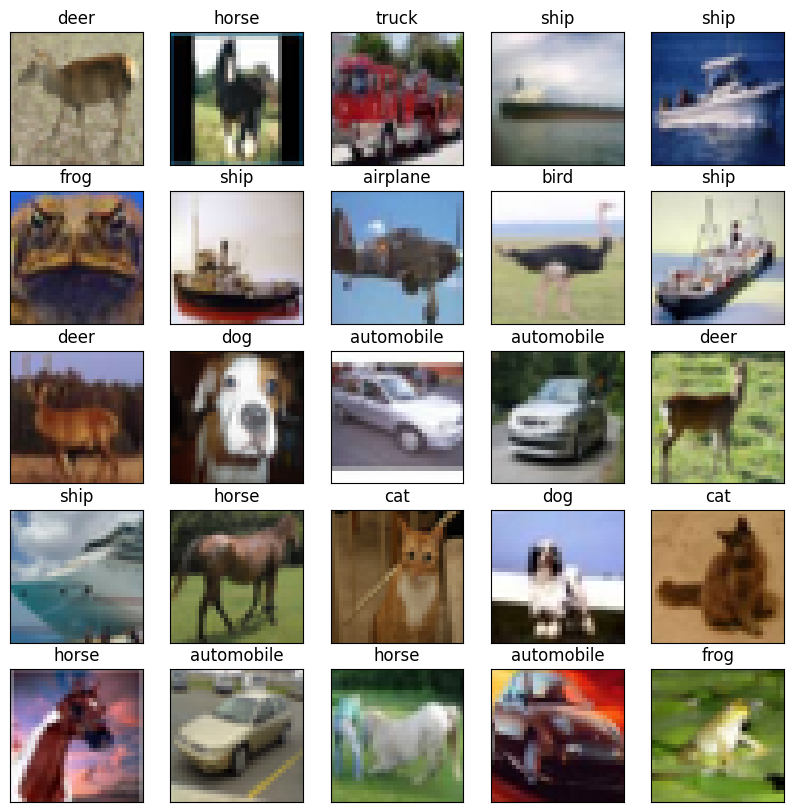

In [1]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

cifar10_data = CIFAR10(root="./data",
                       train=False,download=True,
                       transform=transforms.ToTensor())
cifar10_classes = np.array(["airplane", "automobile", "bird", "cat", "deer",
                            "dog", "frog", "horse", "ship", "truck"])
print("データの数:", len(cifar10_data))

n_image = 25  # 表示する画像の数
cifar10_loader = DataLoader(cifar10_data, batch_size=n_image, shuffle=True)
dataiter = iter(cifar10_loader)  # イテレータ
images, labels = next(dataiter)  # 最初のバッチを取り出す

plt.figure(figsize=(10,10))  # 画像の表示サイズ
for i in range(n_image):
    plt.subplot(5,5,i+1)
    plt.imshow(np.transpose(images[i], (1, 2, 0)))  # チャンネルを一番後ろに
    label = cifar10_classes[labels[i]]
    plt.title(label)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に

plt.show()

In [2]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

affine = transforms.RandomAffine([-15, 15], scale=(0.8, 1.2))  # 回転とリサイズ
flip = transforms.RandomHorizontalFlip(p=0.5)  # 左右反転
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # 平均値を0、標準偏差を1に
to_tensor = transforms.ToTensor()

transform_train = transforms.Compose([affine, flip, to_tensor, normalize])
transform_test = transforms.Compose([to_tensor, normalize])
cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform_test)

# DataLoaderの設定
batch_size = 64
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=len(cifar10_test), shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 畳み込み層:(入力チャンネル数, フィルタ数、フィルタサイズ)
        self.pool = nn.MaxPool2d(2, 2)  # プーリング層:（領域のサイズ, ストライド）
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 256)  # 全結合層
        self.dropout = nn.Dropout(p=0.5)  # ドロップアウト:(p=ドロップアウト率)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = Net()
# net.cuda()  # GPU対応
print(net)
     

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [8]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
x_test, t_test = next(iter(test_loader))
# x_test, t_test = x_test.cuda(), t_test.cuda()
for i in range(20):  # 20エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        # x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    y_test = net(x_test)
    loss_test = loss_fnc(y_test, t_test).item()
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 1.8077643438983146 Loss_Test: 1.5701208114624023
Epoch: 1 Loss_Train: 1.5583225296586372 Loss_Test: 1.4109225273132324
Epoch: 2 Loss_Train: 1.4828002986395756 Loss_Test: 1.3257739543914795
Epoch: 3 Loss_Train: 1.4272782503796355 Loss_Test: 1.3076493740081787
Epoch: 4 Loss_Train: 1.3852971783074577 Loss_Test: 1.2637056112289429
Epoch: 5 Loss_Train: 1.3642161690518069 Loss_Test: 1.231462001800537
Epoch: 6 Loss_Train: 1.34274534884926 Loss_Test: 1.2015289068222046
Epoch: 7 Loss_Train: 1.3206135546764755 Loss_Test: 1.175398588180542
Epoch: 8 Loss_Train: 1.2988983016184834 Loss_Test: 1.1437170505523682
Epoch: 9 Loss_Train: 1.283036736118824 Loss_Test: 1.1243386268615723
Epoch: 10 Loss_Train: 1.26977364913277 Loss_Test: 1.1684762239456177
Epoch: 11 Loss_Train: 1.256680492549906 Loss_Test: 1.102492332458496
Epoch: 12 Loss_Train: 1.2514115829601922 Loss_Test: 1.1486966609954834
Epoch: 13 Loss_Train: 1.2307233000197983 Loss_Test: 1.084987759590149
Epoch: 14 Loss_Train: 1.22

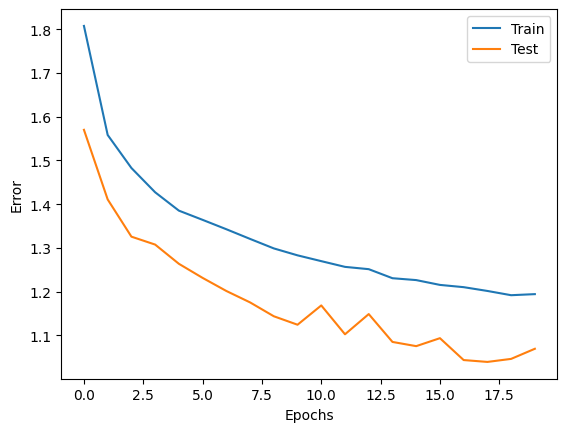

In [9]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()
     

In [10]:
correct = 0
total = 0
net.eval()  # 評価モード
for i, (x, t) in enumerate(test_loader):
    # x, t = x.cuda(), t.cuda()  # GPU対応
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 62.370000000000005%


In [11]:
import torch

# state_dict()の表示
for key in net.state_dict():
    print(key, ": ", net.state_dict()[key].size())
print(net.state_dict()["conv1.weight"][0])  # 　パラメータの一部を表示

# 保存
torch.save(net.state_dict(), "model_cnn.pth")  

conv1.weight :  torch.Size([6, 3, 5, 5])
conv1.bias :  torch.Size([6])
conv2.weight :  torch.Size([16, 6, 5, 5])
conv2.bias :  torch.Size([16])
fc1.weight :  torch.Size([256, 400])
fc1.bias :  torch.Size([256])
fc2.weight :  torch.Size([10, 256])
fc2.bias :  torch.Size([10])
tensor([[[-0.1004,  0.0836, -0.0932,  0.0098,  0.1205],
         [-0.0180,  0.1513, -0.0157, -0.0897,  0.0292],
         [ 0.1067,  0.1697, -0.0540, -0.1141, -0.1430],
         [ 0.1489,  0.1049,  0.0446, -0.0169, -0.1106],
         [ 0.0229,  0.1144, -0.0360, -0.0566,  0.0862]],

        [[-0.0610, -0.0591,  0.0847, -0.0095, -0.1086],
         [ 0.0558,  0.1072,  0.0290, -0.0427, -0.1220],
         [ 0.0143,  0.1033, -0.0515, -0.1733, -0.1036],
         [ 0.0496,  0.0285,  0.0474, -0.1464, -0.0038],
         [-0.0154, -0.0745, -0.0314,  0.0232, -0.1390]],

        [[ 0.1525,  0.0242,  0.0698,  0.0165, -0.1383],
         [ 0.2091,  0.0295,  0.0688, -0.1565, -0.2406],
         [ 0.2210,  0.1850,  0.0879, -0.1409, -0

In [12]:
# 読み込み
net_loaded = Net()
net_loaded.load_state_dict(torch.load("model_cnn.pth", map_location=torch.device("cpu")))  #CPU対応
net_loaded.eval()  # 評価モード

# state_dict()の表示
for key in net_loaded.state_dict():
    print(key, ": ", net.state_dict()[key].size())
print(net_loaded.state_dict()["conv1.weight"][0])  # 　パラメータの一部を表示

conv1.weight :  torch.Size([6, 3, 5, 5])
conv1.bias :  torch.Size([6])
conv2.weight :  torch.Size([16, 6, 5, 5])
conv2.bias :  torch.Size([16])
fc1.weight :  torch.Size([256, 400])
fc1.bias :  torch.Size([256])
fc2.weight :  torch.Size([10, 256])
fc2.bias :  torch.Size([10])
tensor([[[-0.1004,  0.0836, -0.0932,  0.0098,  0.1205],
         [-0.0180,  0.1513, -0.0157, -0.0897,  0.0292],
         [ 0.1067,  0.1697, -0.0540, -0.1141, -0.1430],
         [ 0.1489,  0.1049,  0.0446, -0.0169, -0.1106],
         [ 0.0229,  0.1144, -0.0360, -0.0566,  0.0862]],

        [[-0.0610, -0.0591,  0.0847, -0.0095, -0.1086],
         [ 0.0558,  0.1072,  0.0290, -0.0427, -0.1220],
         [ 0.0143,  0.1033, -0.0515, -0.1733, -0.1036],
         [ 0.0496,  0.0285,  0.0474, -0.1464, -0.0038],
         [-0.0154, -0.0745, -0.0314,  0.0232, -0.1390]],

        [[ 0.1525,  0.0242,  0.0698,  0.0165, -0.1383],
         [ 0.2091,  0.0295,  0.0688, -0.1565, -0.2406],
         [ 0.2210,  0.1850,  0.0879, -0.1409, -0